# BPR: Bayesian Personalized Ranking from Implicit Feedback

## Imports and Data Loading

In [2]:
!git clone https://$GITHUB_TOKEN@github.com/Its-OP/ucu-rs-2026.git

Cloning into 'ucu-rs-2026'...
remote: Enumerating objects: 456, done.
remote: Counting objects: 100% (288/288), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 456 (delta 146), reused 189 (delta 90), pack-reused 168 (from 1)
Receiving objects: 100% (456/456), 79.83 MiB | 7.39 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [3]:
%cd ucu-rs-2026

/Users/anastasiiamazur/Projects/ucu-rs-2026/experiments/BPR/ucu-rs-2026


In [5]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data.dataframes import train, val, test, users, movies
from src.models.bpr import BPRRecommender
from src.models.popularity import PopularityRanker
from src.models.graph import ItemGraphPropagationRanker
from src.eval.offline_ranking import evaluate as evaluate_offline

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("src.eval.eval").setLevel(logging.ERROR)
logging.getLogger("src.eval.offline_ranking").setLevel(logging.ERROR)

Matplotlib is building the font cache; this may take a moment.


In [6]:
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

## 2. Baseline Heuristics

### 2.1 Helpers

In [7]:
def run_offline_eval(model, train_df, eval_df, users_df, movies_df, ks=(10, 20), threshold=4.0, mode="all"):
    report = evaluate_offline(
        model=model,
        train_ratings=train_df,
        test_ratings=eval_df,
        users=users_df,
        movies=movies_df,
        ks=ks,
        threshold=threshold,
        mode=mode,
    )
    rows = []
    for k, m in report.by_k.items():
        rows.append({
            "k": k,
            "ndcg": m.ndcg,
            "precision": m.precision,
            "recall": m.recall,
            "mrr": m.mrr,
            "map": m.map,
            "n_users_evaluated": report.n_users_evaluated,
            "n_skipped": report.n_skipped,
            "skip_rate": report.skip_rate,
            "coverage_rate": report.coverage_rate,
            "avg_list_size": report.avg_list_size,
            "mode": report.mode,
        })
    return report, pd.DataFrame(rows).sort_values("k").reset_index(drop=True)


def to_long_result(df, model_name, split_name, extra=None):
    out = df.copy()
    out["model"] = model_name
    out["split"] = split_name
    if extra:
        for k, v in extra.items():
            out[k] = v
    return out

### 2.2 Results

In [8]:
pop_model = PopularityRanker()
pop_model.fit(train, users=users, movies=movies)

graph_model = ItemGraphPropagationRanker(
    alpha=0.85,
    n_steps=1,
    relevance_threshold=4.0,
    use_rating_weights=False,
)
graph_model.fit(train, users=users, movies=movies)

pop_val_report, pop_val_df = run_offline_eval(pop_model, train, val, users, movies, ks=(10,20), threshold=4.0, mode="all")
graph_val_report, graph_val_df = run_offline_eval(graph_model, train, val, users, movies, ks=(10,20), threshold=4.0, mode="all")

pd.concat([to_long_result(pop_val_df, "popularity_count", "val"), to_long_result(graph_val_df, "item_graph", "val")], 
          axis=0, ignore_index=True)

,k,ndcg,precision,recall,mrr,map,n_users_evaluated,n_skipped,skip_rate,coverage_rate,avg_list_size,mode,model,split
0,10,0.296186,0.262082,0.054551,0.473680,0.180444,1188,4852,0.803311,1.0,20.0,all,popularity_count,val
1,20,0.284452,0.243275,0.087654,0.479262,0.150884,1188,4852,0.803311,1.0,20.0,all,popularity_count,val
2,10,0.291610,0.266307,0.056036,0.447596,0.181979,1188,4852,0.803311,1.0,20.0,all,item_graph,val
3,20,0.278821,0.244054,0.088172,0.452750,0.151903,1188,4852,0.803311,1.0,20.0,all,item_graph,val


## 3. Bayesian Personalized Ranking

### 3.1 Implementation Recap

1. Scoring function: $x_{ui} = b_i + \mathbf{p}_u^\top \mathbf{q}_i$, 
where $\mathbf{p}_u \in \mathbb{R}^d$ is the user embedding, $\mathbf{q}_i \in \mathbb{R}^d$ is the item embedding, and $b_i$ is an item bias.

2. Loss: minimizes the negative log-likelihood $\mathcal{L}*{uij} = -\log \sigma(x*{ui} - x_{uj}) + \lambda \left(\lVert \mathbf{p}_u\rVert^2 + \lVert \mathbf{q}_i\rVert^2 + \lVert \mathbf{q}_j\rVert^2 + b_i^2 + b_j^2 \right)$, where $\sigma(\cdot)$ is the sigmoid function and $\lambda$ the L2 regularization coefficient.

3. Positive interactions: $\text{Rating} >= 4.0$.

4. Negative sampling strategies:
  * *uniform* over items;
  * *popularity-biased* sampling with $p(i) \propto \text{count}(i)^\alpha$(computed from the training split only, with $\alpha$ configurable).

5. Negativ pool switch:

  * *unseen* (recommended): sample $j$ from items unseen by the user in the training split (observed vs unobserved);
  * *non_positive*: sample $j$ from items not in the positive set (treats low-rated items as potential negatives).

6. Inference: apply seen-item masking to exclude items already interacted with in the provided ratings (training split).

7. Cold-start: fall back to a global popularity prior computed from the training data, still applying seen-item masking where applicable.

For full details, see: *`docs/models/bpr.md`*.

### 3.2 Hyperparameter Configurations

In [11]:
bpr_grid = [
    {"name": "bpr_u_uniform", "negative_sampling": "uniform", "negative_pool": "unseen"},
    {"name": "bpr_u_pop", "negative_sampling": "popularity","negative_pool": "unseen"},
    {"name": "bpr_np_uniform","negative_sampling": "uniform", "negative_pool": "non_positive"},
    {"name": "bpr_np_pop", "negative_sampling": "popularity","negative_pool": "non_positive"},
]

# shared params
base_bpr_params = dict(
    n_factors=64,
    n_epochs=20,
    lr=0.01,
    regularization=0.01,
    n_samples_per_epoch=0,
    threshold=4.0,
    popularity_alpha=0.75,
    random_state=42,
)

### 3.3 Training and Evaluation

Train on TRAIN subset, get intermediate evaluation results on VAL subset

In [ ]:
bpr_models = {}
bpr_histories = {}
val_rows = []

for cfg in bpr_grid:
    params = base_bpr_params.copy()
    params["negative_sampling"] = cfg["negative_sampling"]
    params["negative_pool"] = cfg["negative_pool"]

    model = BPRRecommender(**params)
    model.fit(train, users=users, movies=movies)

    bpr_models[cfg["name"]] = model
    bpr_histories[cfg["name"]] = model.loss_history_

    _, val_df = run_offline_eval(model, train, val, users, movies, ks=(10,20), threshold=4.0, mode="all")
    val_rows.append(to_long_result(val_df, cfg["name"], "val", {
        "negative_sampling": cfg["negative_sampling"],
        "negative_pool": cfg["negative_pool"],
    }))

**Model identification**

* `model`  
  name of the evaluated model variant (e.g., `bpr_u_uniform`, `bpr_u_pop`, `bpr_np_uniform`, `bpr_np_pop`, or a heuristic baseline name).

* `split`  
  evaluation split used as ground truth:
  * `val`: validation split (used for tuning).
  * `test`: test split (used for final reporting).

* `negative_sampling`  
  negative sampling **distribution** used during BPR training:
  * `uniform`: sample negatives uniformly from the item catalog.
  * `popularity`: sample negatives proportional to item popularity,  
    $p(j) \propto \text{count}(j)^{\alpha}$, where $\alpha$ is `popularity_alpha`.

* `negative_pool`  
  negative sampling **candidate pool** for BPR (what is excluded for each user):
  * `unseen`: negatives are sampled from items **unseen by the user in the training split**
    (i.e., exclude all train-seen items for that user). This matches the classic implicit
    “observed vs unobserved” BPR setting.
  * `non_positive`: negatives are sampled from items **not in the positive set**
    (i.e., exclude only positives; allows sampling items the user interacted with but rated below the positive threshold).

* `mode`  
  user-subset mode used by the evaluator:
  * `all`: evaluate on all users provided to the model.
  * `warm_only`: evaluate only on “warm” users as defined by the evaluator
    (users with sufficient training history under its definition).

---

**User accounting (who is included)**

* `n_users_evaluated`  
  number of users included in metric averaging for this run.  
  In practice, this corresponds to users who are **eligible** under the relevance definition
  (i.e., have at least one relevant item in the evaluation split); users without relevant
  ground truth do not contribute to Precision/Recall/MRR/MAP.

* `n_skipped`  
  number of users excluded from metric averaging (typically because they have no relevant items
  in the evaluation split under the relevance threshold).

* `skip_rate`  
  fraction of users skipped among users for whom the model produced a recommendation list: $\text{skip\_rate} = \frac{n\_\text{skipped}}{n\_\text{predicted}}$.

---

**Recommendation list diagnostics**

* `coverage_rate`  
  fraction of users who received at least the minimum required number of recommendations
  (depending on evaluator settings, typically “list length ≥ min(K)”): $\text{coverage\_rate} = \frac{\{\text{users with sufficiently long rec list}\}}{n\_\text{predicted}}$.
  Low coverage can occur due to aggressive filtering (e.g., seen-item masking) or limited candidate pools.

* `avg_list_size`  
  average number of recommended items returned per user. This is often close to the requested $K$,
  but can be smaller if many candidates are filtered out (seen-item masking) or if the model fails
  to produce enough distinct items.

---

**Ranking metrics**

All ranking metrics are computed at cutoff `k` and then averaged across `n_users_evaluated`.

* `k`  
  cutoff used for all ranking metrics.

* `ndcg` (NDCG@K)  
  normalized Discounted Cumulative Gain at `k`: emphasizes placing relevant items higher in the ranking,
  with stronger weight on top positions.

* `precision` (Precision@K)  
  fraction of recommended items in the top-`k` that are relevant: $\text{Precision@K} = \frac{\{\text{relevant items in top-K}\}}{K}$.

* `recall` (Recall@K)  
  fraction of relevant items in the evaluation split that are retrieved in the top-`k`: $\text{Recall@K} = \frac{\{\text{relevant items in top-K}\}}{\{\text{relevant items in ground truth}\}}$.

* `mrr` (MRR@K)  
  mean Reciprocal Rank at `k`: for each user, find the rank $r$ of the first relevant item within top-`k`,
  assign $1/r$ (or $0$ if none), then average over evaluated users.

* `map` (MAP@K)  
  mean Average Precision at `k`: for each user, compute the average precision over the top-`k` list
  (precision accumulated at each position where a relevant item appears), then average over evaluated users.

In [ ]:
bpr_val_all = pd.concat(val_rows, ignore_index=True)
bpr_val_all.sort_values(["k", "ndcg"], ascending=[True, False])

,k,ndcg,precision,recall,mrr,map,n_users_evaluated,n_skipped,skip_rate,coverage_rate,avg_list_size,mode,model,split,negative_sampling,negative_pool
0,10,0.296268,0.264964,0.055783,0.466840,0.179760,1188,4852,0.803311,1.0,20.0,all,bpr_u_uniform,val,uniform,unseen
4,10,0.295926,0.264197,0.055666,0.468045,0.179816,1188,4852,0.803311,1.0,20.0,all,bpr_np_uniform,val,uniform,non_positive
2,10,0.282998,0.251662,0.052650,0.447222,0.170202,1188,4852,0.803311,1.0,20.0,all,bpr_u_pop,val,popularity,unseen
6,10,0.281619,0.252865,0.053737,0.448881,0.170740,1188,4852,0.803311,1.0,20.0,all,bpr_np_pop,val,popularity,non_positive
5,20,0.286332,0.245389,0.089755,0.474380,0.150923,1188,4852,0.803311,1.0,20.0,all,bpr_np_uniform,val,uniform,non_positive
1,20,0.285078,0.245169,0.089452,0.472883,0.150422,1188,4852,0.803311,1.0,20.0,all,bpr_u_uniform,val,uniform,unseen
3,20,0.272470,0.232476,0.084989,0.453118,0.141677,1188,4852,0.803311,1.0,20.0,all,bpr_u_pop,val,popularity,unseen
7,20,0.271611,0.233618,0.085949,0.454978,0.141992,1188,4852,0.803311,1.0,20.0,all,bpr_np_pop,val,popularity,non_positive


### 3.4 Convergence Analysis

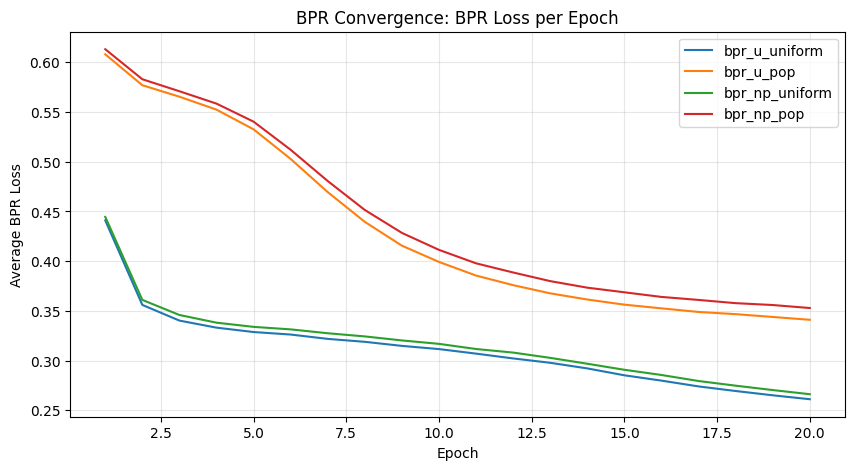

In [13]:
plt.figure(figsize=(10,5))
for name, hist in bpr_histories.items():
    plt.plot(range(1, len(hist)+1), hist, label=name)
plt.xlabel("Epoch")
plt.ylabel("Average BPR Loss")
plt.title("BPR Convergence: BPR Loss per Epoch")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Comparison

Chosen best BPR config on VAL subset compared to 2 best heuristic representatives of their families on the TEST subset

### 3.1 Evaluation Metrics

In [14]:
best_bpr_row = (
    bpr_val_all[bpr_val_all["k"] == 10]
    .sort_values("ndcg", ascending=False)
    .iloc[0]
)
best_bpr_name = best_bpr_row["model"]
best_bpr_model = bpr_models[best_bpr_name]

pop_test_report, pop_test_df = run_offline_eval(pop_model, train, test, users, movies, ks=(10,20), threshold=4.0, mode="all")
graph_test_report, graph_test_df = run_offline_eval(graph_model, train, test, users, movies, ks=(10,20), threshold=4.0, mode="all")
bpr_test_report, bpr_test_df = run_offline_eval(best_bpr_model, train, test, users, movies, ks=(10,20), threshold=4.0, mode="all")

compare_test = pd.concat([
    to_long_result(pop_test_df, "popularity_count", "test"),
    to_long_result(graph_test_df, "item_graph", "test", {"alpha":0.85, "steps":1, "graph_threshold":4.0, "use_rating_weights":False}),
    to_long_result(bpr_test_df, best_bpr_name, "test"),
], ignore_index=True)

compare_test.sort_values(["k","ndcg"], ascending=[True,False])

,k,ndcg,precision,recall,mrr,map,n_users_evaluated,n_skipped,skip_rate,coverage_rate,avg_list_size,mode,model,split,alpha,steps,graph_threshold,use_rating_weights
4,10,0.239079,0.211514,0.050425,0.384543,0.136440,1347,4693,0.776987,1.0,20.0,all,bpr_u_uniform,test,NaN,NaN,NaN,NaN
2,10,0.235137,0.212660,0.048792,0.368333,0.139859,1347,4693,0.776987,1.0,20.0,all,item_graph,test,0.85,1.0,4.0,False
0,10,0.217267,0.192732,0.042059,0.351185,0.123275,1347,4693,0.776987,1.0,20.0,all,popularity_count,test,NaN,NaN,NaN,NaN
5,20,0.230476,0.191643,0.075829,0.391896,0.111964,1347,4693,0.776987,1.0,20.0,all,bpr_u_uniform,test,NaN,NaN,NaN,NaN
3,20,0.223923,0.191321,0.072909,0.375044,0.114219,1347,4693,0.776987,1.0,20.0,all,item_graph,test,0.85,1.0,4.0,False
1,20,0.210374,0.175673,0.065788,0.358654,0.100122,1347,4693,0.776987,1.0,20.0,all,popularity_count,test,NaN,NaN,NaN,NaN


### 3.2 Head vs Tail Analysis

Evaluate on all first to keep same predictions behavior, then slice test_ratings into head/tail and evaluate again

In [15]:
item_counts = train.groupby("MovieID").size().rename("train_count").sort_values(ascending=False)
n_items = len(item_counts)
head_n = max(1, int(0.2 * n_items))
head_items = set(item_counts.head(head_n).index.tolist())
tail_items = set(item_counts.iloc[head_n:].index.tolist())

print(f"Items total={n_items}, head={len(head_items)}, tail={len(tail_items)}")


def eval_head_tail(report_model, train_df, eval_df, users_df, movies_df, ks=(10,20), threshold=4.0):
    eval_head = eval_df[eval_df["MovieID"].isin(head_items)].copy()
    eval_tail = eval_df[eval_df["MovieID"].isin(tail_items)].copy()

    _, df_head = run_offline_eval(report_model, train_df, eval_head, users_df, movies_df, ks=ks, threshold=threshold, mode="all")
    _, df_tail = run_offline_eval(report_model, train_df, eval_tail, users_df, movies_df, ks=ks, threshold=threshold, mode="all")

    df_head["segment"] = "head"
    df_tail["segment"] = "tail"

    return pd.concat([df_head, df_tail], ignore_index=True)

pop_ht = eval_head_tail(pop_model, train, test, users, movies, ks=(10,20), threshold=4.0)
graph_ht = eval_head_tail(graph_model, train, test, users, movies, ks=(10,20), threshold=4.0)
bpr_ht = eval_head_tail(best_bpr_model, train, test, users, movies, ks=(10,20), threshold=4.0)

head_tail_compare = pd.concat([
    to_long_result(pop_ht, "popularity_count", "test"),
    to_long_result(graph_ht, "item_graph", "test"),
    to_long_result(bpr_ht, best_bpr_name, "test"),
], ignore_index=True)

head_tail_compare.sort_values(["k", "segment", "ndcg"], ascending=[True, True, False]).head(30)

Items total=3651, head=730, tail=2921


,k,ndcg,precision,recall,mrr,map,n_users_evaluated,n_skipped,skip_rate,coverage_rate,avg_list_size,mode,segment,model,split
8,10,0.252704,0.220572,0.069936,0.397805,0.144521,1300,4740,0.784768,1.0,20.0,all,head,bpr_u_uniform,test
4,10,0.247517,0.220441,0.065565,0.381649,0.147260,1300,4740,0.784768,1.0,20.0,all,head,item_graph,test
0,10,0.228272,0.199774,0.057053,0.363881,0.129284,1300,4740,0.784768,1.0,20.0,all,head,popularity_count,test
10,10,0.000521,0.000483,0.000269,0.001276,0.000172,1241,4799,0.794536,1.0,20.0,all,tail,bpr_u_uniform,test
2,10,0.000000,0.000000,0.000000,0.000000,0.000000,1241,4799,0.794536,1.0,20.0,all,tail,popularity_count,test
6,10,0.000000,0.000000,0.000000,0.000000,0.000000,1241,4799,0.794536,1.0,20.0,all,tail,item_graph,test
9,20,0.249814,0.201372,0.101491,0.405424,0.122787,1300,4740,0.784768,1.0,20.0,all,head,bpr_u_uniform,test
5,20,0.240981,0.200438,0.097029,0.388603,0.123452,1300,4740,0.784768,1.0,20.0,all,head,item_graph,test
1,20,0.225989,0.183171,0.086600,0.371621,0.107870,1300,4740,0.784768,1.0,20.0,all,head,popularity_count,test
11,20,0.000461,0.000443,0.000311,0.001391,0.000124,1241,4799,0.794536,1.0,20.0,all,tail,bpr_u_uniform,test
